# Simple regression model selection


In [1]:
from typing import NamedTuple
import chex
import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp
from pcv.inference import (run_cv_sel, fold_posterior,
    estimate_elpd, rhat_summary, mv_ess_folds, pred_ess_folds)
from pcv.welford import *
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

## Model definition

Gaussian linear regression

In [2]:
class Theta(NamedTuple):
    beta: jax.Array
    sigsq: jax.Array

In [3]:
y_key, X_key = jax.random.split(jax.random.PRNGKey(0))
N = 100
beta0 = jnp.array([1.0, 1.0, 1.0, 0.3])
p = len(beta0)
sigsq0 = jnp.array(2.0)
X = tfd.Normal(loc=0, scale=1).sample(sample_shape=(N, p), seed=X_key)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


To break inference, simply inject an outlier into the data. Remember jax arrays are immutable so we need this stange syntax.

In [4]:
y = X@beta0 + tfd.Normal(loc=0, scale=jnp.sqrt(sigsq0)).sample(sample_shape=(N,), seed=y_key)

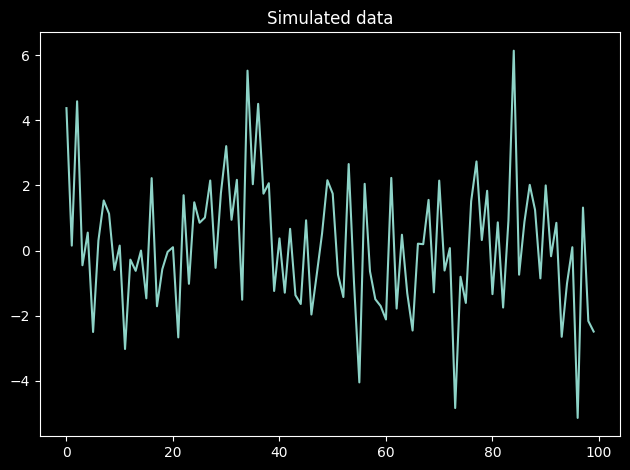

In [5]:
plt.plot(y)
plt.title('Simulated data')
plt.tight_layout()

In [6]:
# use exp to transform sigsq to unconstrained space
sigsq_t = tfb.Exp()

beta_prior = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=jnp.ones(p))
sigsq_prior = tfd.Gamma(concentration=1.0, rate=1.0)


def logjoint_density(theta: Theta, fold_id: int, model_id: int) -> jax.Array:
    """Log joint density for a given fold.
    
    Args:
      theta: model parameters
      fold_id: zero-based fold id for training set
      model_id: 0 for model A, 1 for model B
    """
    # transform to constrained space
    sigsq = sigsq_t.forward(theta.sigsq)
    sigsq_ldj = sigsq_t.forward_log_det_jacobian(theta.sigsq)
    # prior is same for all folds
    lp = beta_prior.log_prob(theta.beta) + sigsq_prior.log_prob(sigsq)
    # likelihood for fold
    ll_mask = ((jnp.arange(N) % 5) != fold_id).astype(jnp.float32)
    # model A has all the predictors, model B is missing the last predictor
    beta_mask = jnp.where(model_id == 0, jnp.ones(p), jnp.concatenate([jnp.ones(p-1), jnp.zeros(1)]))
    ll_contribs = tfd.Normal(loc=X @ (theta.beta * beta_mask), scale=jnp.sqrt(sigsq)).log_prob(y)
    ll = (ll_mask * ll_contribs).sum()
    return lp + ll + sigsq_ldj


# predictive density log p(y_train|theta)
def log_pred(theta, fold_id, model_id):
    # transform to constrained space
    sigsq = sigsq_t.forward(theta.sigsq)
    pred_mask = (jnp.arange(N) % 5) == fold_id
    beta_mask = jnp.where(model_id == 0, jnp.ones(p), jnp.concatenate([jnp.ones(p-1), jnp.zeros(1)]))
    ll_contribs = tfd.Normal(loc=X @ (theta.beta * beta_mask), scale=jnp.sqrt(sigsq)).log_prob(y)
    return (pred_mask * ll_contribs).sum()


# random initialization in the constrained parameter space
def make_initial_pos(key):
    k1, k2 = jax.random.split(key)
    theta = Theta(
      beta=jax.random.normal(key=k1, shape=(p,)),
      sigsq=jax.random.normal(key=k2))
    return theta

## Inference

Ok let's actually run some MCMC

In [7]:
inference_key = jax.random.PRNGKey(42)

Run the full-data posterior with the offline inference loop, saving draws.

In [8]:
results = run_cv_sel(
       prng_key=inference_key,
       logjoint_density=logjoint_density,
       log_p=log_pred,
       make_initial_pos=make_initial_pos,
       num_folds=5,
       num_chains=4,
       batch_size=100,
       warmup_iter=1000,
       max_batches=50
)

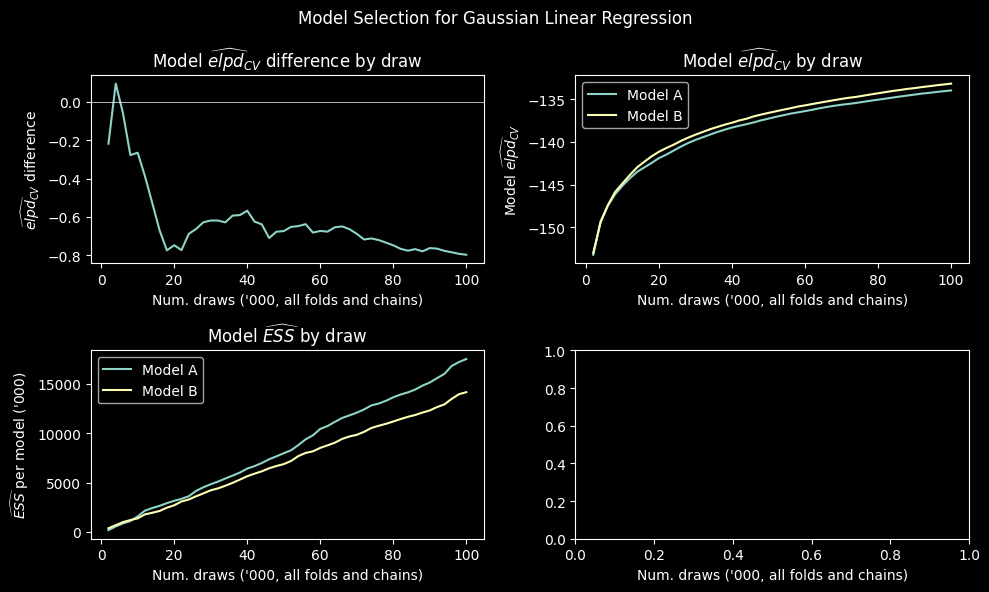

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
((p_diff, p_elpds), (p_ess, p_rhat)) = axes

p_diff.plot(results['draws'] * 5e-3, results['elpd_diff'], linestyle='solid')
p_diff.axhline(y=0, color='w', linestyle='solid', linewidth=0.5)
p_diff.set_title(r'Model $\widehat{elpd}_{CV}$ difference by draw')
p_diff.set_xlabel('Num. draws (all folds, chains)')
p_diff.set_ylabel(r'$\widehat{elpd}_{CV}$ difference')

p_elpds.plot(results['draws'] * 5e-3, results['total_elpd'], linestyle='solid')
p_elpds.set_title(r'Model $\widehat{elpd}_{CV}$ by draw')
p_elpds.legend(['Model A', 'Model B'])
p_elpds.set_ylabel(r'Model $\widehat{elpd}_{CV}$')

p_ess.plot(results['draws'] * 5e-3, results['total_ess'], linestyle='solid')
p_ess.set_title(r'Model $\widehat{ESS}$ by draw')
p_ess.legend(['Model A', 'Model B'])
p_ess.set_ylabel(r"$\widehat{ESS}$ per model ('000)")

for rax in axes:
    for ax in rax:
        ax.set_xlabel("Num. draws ('000, all folds and chains)")

fig.suptitle("Model Selection for Gaussian Linear Regression")
fig.tight_layout()

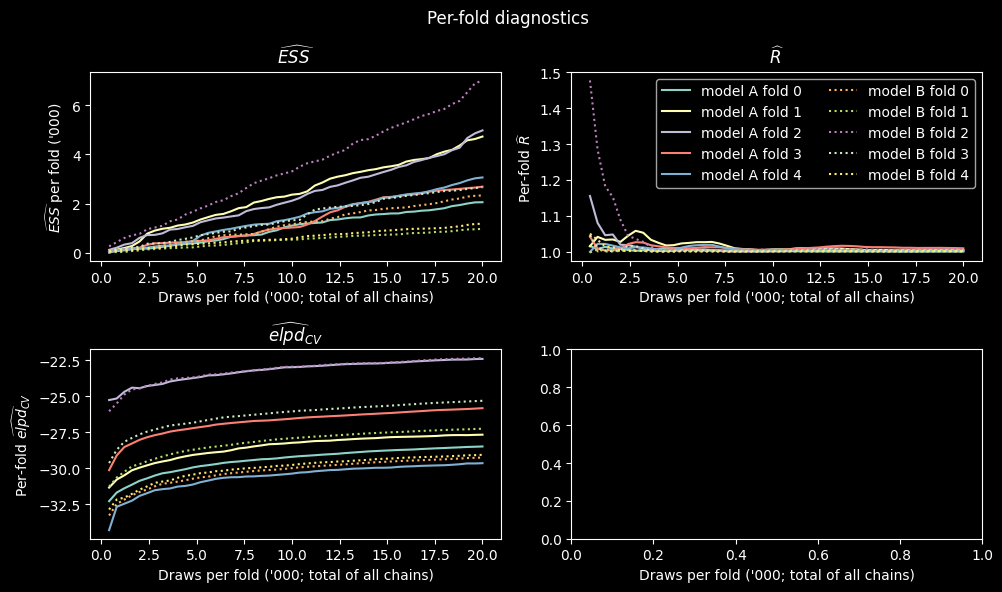

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
((p_ess, p_rhat), (p_elpds, _)) = axes

p_ess.plot(results['draws']*1e-3, results['ess'][:,:5]*1e-3, linestyle='solid')
p_ess.plot(results['draws']*1e-3, results['ess'][:,5:]*1e-3, linestyle='dotted')
p_ess.set_title(r'$\widehat{ESS}$')
p_ess.set_ylabel(r"$\widehat{ESS}$ per fold ('000)")

p_rhat.plot(results['draws']*1e-3, results['rhat'][:,:5], linestyle='solid')
p_rhat.plot(results['draws']*1e-3, results['rhat'][:,5:], linestyle='dotted')
p_rhat.set_title(r'$\widehat{R}$')
p_rhat.set_ylabel(r'Per-fold $\widehat{R}$')
p_rhat.legend([f'model {"A" if i <= 4 else "B"} fold {i % 5}' for i in range(10)], ncol=2)

p_elpds.plot(results['draws']*1e-3, results['elpd'][:,:5], linestyle='solid')
p_elpds.plot(results['draws']*1e-3, results['elpd'][:,5:], linestyle='dotted')
p_elpds.set_title(r'$\widehat{elpd}_{CV}$')
p_elpds.set_ylabel(r'Per-fold $\widehat{elpd}_{CV}$')

for rax in axes:
    for ax in rax:
        ax.set_xlabel("Draws per fold ('000; total of all chains)")

fig.suptitle('Per-fold diagnostics')

plt.tight_layout()
plt.show()